In [ ]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [ ]:
#mount Google Drive
from google.colab import drive
from tabulate import tabulate
drive.mount('/content/drive')
csv = pd.read_csv("/content/drive/MyDrive/Applied_Data_Science/sex-ratio-at-birth.csv")

#load the dataset and print its info
print(tabulate(csv.head(), headers='keys', tablefmt='grid'), csv.info())

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18944 entries, 0 to 18943
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Entity                                              18944 non-null  object 
 1   Code                                                17612 non-null  object 
 2   Year                                                18944 non-null  int64  
 3   Sex ratio - Sex: all - Age: 0 - Variant: estimates  18944 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 592.1+ KB
+----+-------------+--------+--------+------------------------------------------------------+
|    | Entity      | Code   |   Year |   Sex ratio - Sex: all - Age: 0 - Variant: estimates |
+====+=============+========+========+======================================================+
|  0 | Afghanistan | AFG    |   19

In [ ]:
#drop rows with missing values
csv = csv.dropna(subset=['Sex ratio - Sex: all - Age: 0 - Variant: estimates', 'Year'])

#expected sex ratio (105 boys per 100 girls)
expected_ratio = 105 / (100 + 105)

#function to perform z-test with customisable alpha
def z_test(observed_ratio, n, alpha=0.05):
    std_error = np.sqrt(expected_ratio * (1 - expected_ratio) / n)
    z_score = (observed_ratio - expected_ratio) / std_error
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    return z_score, p_value

In [ ]:
#identify anomalies with a customisable alpha level
alpha = 0.05
anomalies = []

#loop over rows to perform the z-test
for _, row in csv.iterrows():
    observed_ratio = row['Sex ratio - Sex: all - Age: 0 - Variant: estimates']
    n = 1

    z_score, p_value = z_test(observed_ratio, n, alpha)

    if p_value < alpha:
        anomalies.append({'Country': row['Entity'], 'Year': row['Year'],
                          'Observed Ratio': observed_ratio, 'Z-Score': z_score,
                          'P-Value': p_value})

#convert anomalies to a dataFrame
anomalies_df = pd.DataFrame(anomalies)
print(anomalies_df)

           Country  Year  Observed Ratio     Z-Score  P-Value
0      Afghanistan  1950       99.845600  198.725928      0.0
1      Afghanistan  1951      101.636910  202.309614      0.0
2      Afghanistan  1952      101.716720  202.469282      0.0
3      Afghanistan  1953      101.792810  202.621507      0.0
4      Afghanistan  1954      101.880745  202.797429      0.0
...            ...   ...             ...         ...      ...
18939     Zimbabwe  2019      101.609760  202.255298      0.0
18940     Zimbabwe  2020      101.658680  202.353167      0.0
18941     Zimbabwe  2021      101.701580  202.438993      0.0
18942     Zimbabwe  2022      101.745490  202.526839      0.0
18943     Zimbabwe  2023      101.779960  202.595799      0.0

[18944 rows x 5 columns]


In [ ]:
csv['Year'] = csv['Year'].astype(int)

#count and filter top 40 countries with most anomalies
anomaly_counts = anomalies_df['Country'].value_counts()
top_40 = anomaly_counts.head(40).index
csv_filtered = csv[csv['Entity'].isin(top_40)]

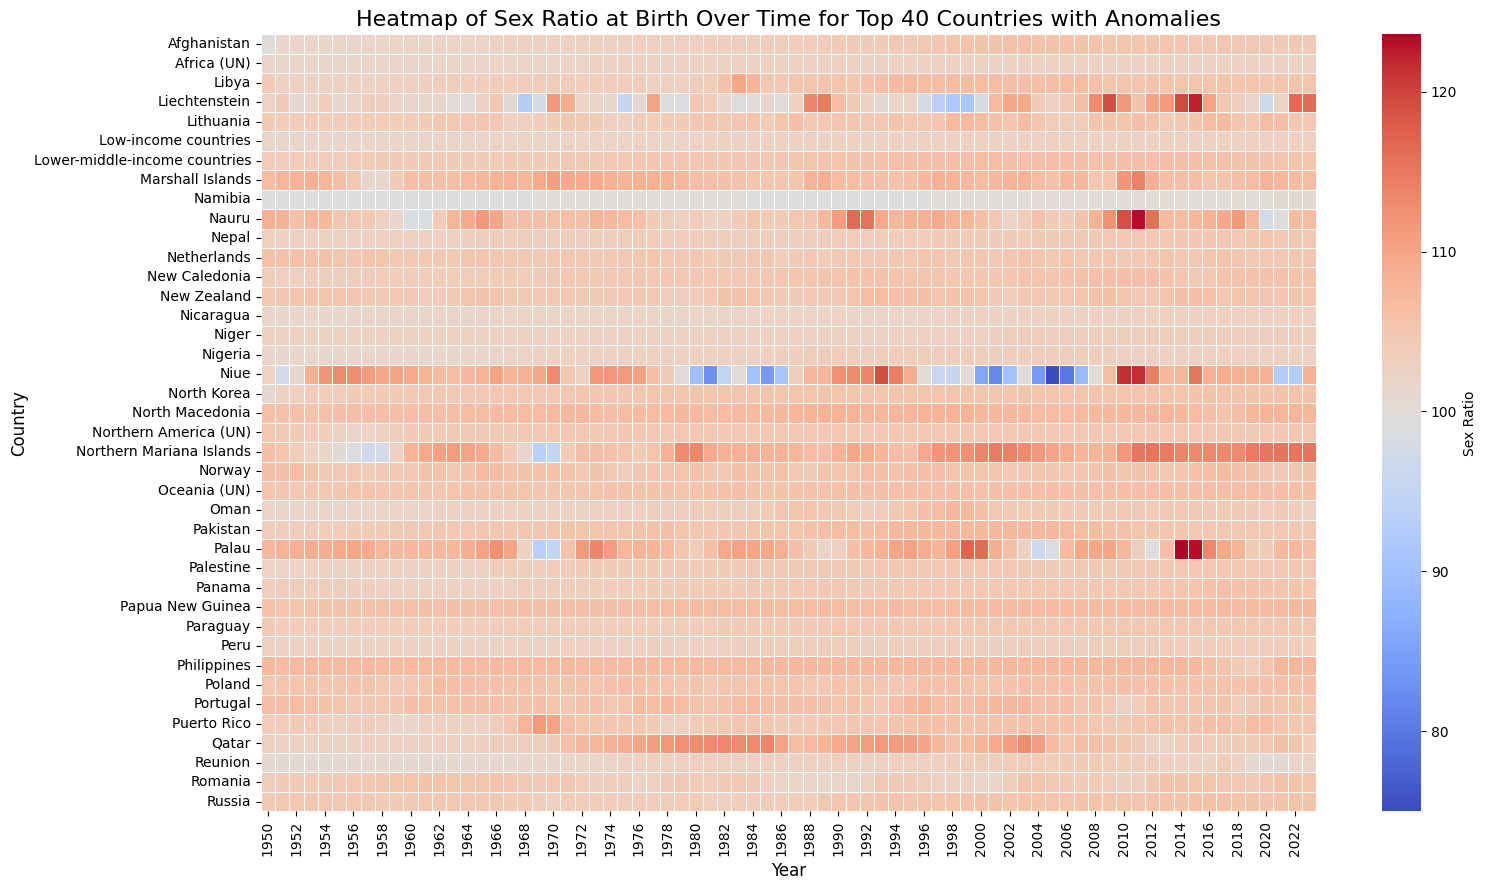

In [ ]:
#create pivot table for the heatmap
pivot_table = csv_filtered.pivot_table(
    index='Entity',
    columns='Year',
    values='Sex ratio - Sex: all - Age: 0 - Variant: estimates'
)

#visualise the heatmap
plt.figure(figsize=(16, 9))
sns.heatmap(
    pivot_table,
    cmap='coolwarm',
    annot=False,
    fmt='.2f',
    cbar_kws={'label': 'Sex Ratio'},
    linewidths=0.5
)

#highlight anomalies on the heatmap
for _, anomaly in anomalies_df.iterrows():
    country = anomaly['Country']
    year = anomaly['Year']
    observed_ratio = anomaly['Observed Ratio']

#display the heatmap
plt.title('Heatmap of Sex Ratio at Birth Over Time for Top 40 Countries with Anomalies', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()